In [3]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [4]:
import scanpy as sc
import mojitoo  
import numpy as np

# Import the evaluation utilities
from utils.eval_utils import (
    compute_ari_nmi,
    compute_silhouette,
    compute_structure_preservation
)

In [5]:
protein_data = sc.read_h5ad("./../datasets/data/processed/LUNG-CITE_ADT.h5ad")
rna_data = sc.read_h5ad("./../datasets/data/processed/LUNG-CITE_RNA.h5ad")

In [6]:
adt = protein_data
rna = rna_data


protein_data.obsm["pca"] = rna.obsm["X_pca"]
protein_data.obsm["apca"] = adt.obsm["X_apca"]


mojitoo.mojitoo(protein_data, reduction_list=["pca", "apca"],  dims_list=(range(50), range(1,50)),reduction_name='mojitoo', overwrite=True)

1 round cc 43


c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


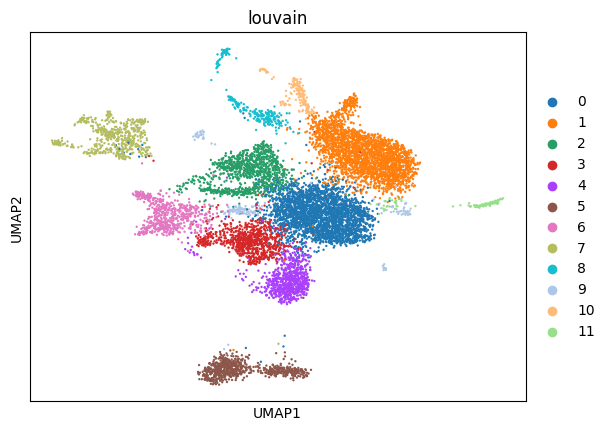

In [7]:
# 2) Build neighbor graph, run clustering
sc.pp.neighbors(protein_data, use_rep='mojitoo')
sc.tl.louvain(protein_data, resolution=0.5)
sc.tl.umap(protein_data)

# 3) Visualize
sc.pl.embedding(protein_data, basis='umap', color='louvain')

In [9]:

# 4) Evaluate ARI and NMI
ari, nmi = compute_ari_nmi(
    adata=protein_data,
    cluster_key="louvain",
    truth_key="celltype"  
)
print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Normalized Mutual Information: {nmi:.3f}")

# ARI should be between 0.5 to 0.9 depending on the dataset and number of cell types (above 0.7 means good clustering)
# NMI typically between 0.5-0.8

Adjusted Rand Index: 0.545
Normalized Mutual Information: 0.672


In [10]:
# 5) Evaluate Silhouette Score
sil_score = compute_silhouette(
    adata=protein_data,
    embedding_key="mojitoo",
    cluster_key="louvain"
)
print(f"Silhouette Score: {sil_score:.3f}")

# ranges from -1 (worst) to +1 (best) 0.2-0.6 common for scRNA-seq

# 6) Evaluate Structure Preservation
structure_corr = compute_structure_preservation(
    adata=protein_data,
    integrated_key="mojitoo",
    original_keys=["pca", "apca"]
)
print("Structure Preservation Correlations:")
for k, (r, p) in structure_corr.items():
    print(f" - {k}: r={r:.3f}, p={p:.1e}")

# for MOJITOO should be 0.5-0.8

Silhouette Score: 0.036
Structure Preservation Correlations:
 - pca: r=0.889, p=0.0e+00
 - apca: r=0.538, p=0.0e+00
